In [ ]:
import os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))


In [2]:
import json
import math
from collections import namedtuple
from typing import Any, Dict, List

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm, tnrange
from numpy import typing as npt
from tensorflow import keras
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from src import ROOT_DIR


In [4]:
def load_glow(hps_path: str):
    hps: Dict[str, Any]
    with open(hps_path, "r") as json_file:
        hps = json.load(json_file)

    coupling = None
    if self.hps["COUPLING_BIJECTOR_FN"] in ["GlowDefaultNetwork", "tfb.GlowDefaultNetwork"]:
        coupling = tfb.GlowDefaultNetwork
    elif self.hps["COUPLING_BIJECTOR_FN"] == "GlowAdditiveNetwork":
        coupling = GlowAdditiveNetwork

    glow = tfb.Glow(
        output_shape=hps["OUTPUT_SHAPE"],
        num_glow_blocks=hps["NUM_GLOW_BLOCKS"],
        num_steps_per_block=hps["NUM_STEPS_PER_BLOCK"],
        coupling_bijector_fn=coupling,
        exit_bijector_fn=tfb.GlowDefaultExitNetwork,
        grab_after_block=hps["GRAB_AFTER_BLOCK"],
        use_actnorm=hps["USE_ACTNORM"],
        seed=hps["SEED"],
        validate_args=True,
    )

    z_shape = glow.inverse_event_shape(hps["OUTPUT_SHAPE"])
    pz = tfd.Sample(tfd.Normal(0.0, 1.0), z_shape)
    px = glow(pz)

    checkpoint = tf.train.Checkpoint(glow)

    safe_path = hps_path.replace("hyperparameters.json", "", 1)
    checkpoint_path = f"{safe_path}/checkpoints/ckpt-{math.floor(self.hps['EPOCHS'] / self.hps['CHECKPOINT_FREQ']) + 1}"
    status = checkpoint.restore(checkpoint_path)
    status.assert_consumed().assert_existing_objects_matched().assert_nontrivial_match()

    print(f"Loaded: {checkpoint_path}")

    return glow, pz, px, hps


In [5]:
glow, pz, px, hps = load_glow(
    f"{ROOT_DIR}/glow/safe/128-2_2022-09-20_17:36:27/hyperparameters.json"
)


2022-10-14 10:07:54.100294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 10:07:54.141672: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-14 10:07:55.831290: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Loaded: /home/lukas/HESSENBOX-DA/Bachelor-Thesis/Ergebnisse/TFP GLOW/128-2_2022-09-20_17:36:27/checkpoints/ckpt-11


In [6]:
def load_image(path: str) -> tf.Tensor:
    return tf.convert_to_tensor(keras.utils.img_to_array(keras.utils.load_img(path)))


In [7]:
def preprocess(tensor: tf.Tensor) -> tf.Tensor:
    tensor = tf.cast(tensor, tf.float32)
    tensor = tf.image.central_crop(tensor, hps["CENTRAL_CROP_FRACTION"])
    tensor = tf.image.resize(tensor, (hps["IMAGE_SIZE"], hps["IMAGE_SIZE"]))

    tensor = tensor / 255 - 0.5
    return tensor


In [15]:
def depreprocess(tensor: tf.Tensor) -> tf.Tensor:
    return tf.clip_by_value(tensor + 0.5, 0.0, 1.0)


In [10]:
img1 = load_image(f"{ROOT_DIR}/data/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0002_36648.jpg")
img1 = preprocess(img1)

img2 = load_image(f"{ROOT_DIR}/data/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0014_36708.jpg")
img2 = preprocess(img2)

img3 = load_image(f"{ROOT_DIR}/data/Bird/Icteridae/Scott_Oriole/Scott_Oriole_0010_795852.jpg")
img3 = preprocess(img3)

img4 = load_image(f"{ROOT_DIR}/data/Bird/Icteridae/Bobolink/Bobolink_0049_9540.jpg")
img4 = preprocess(img4)


tf.Tensor(-0.4993523, shape=(), dtype=float32) tf.Tensor(0.4923694, shape=(), dtype=float32)
tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.4934436, shape=(), dtype=float32)
tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.49951744, shape=(), dtype=float32)


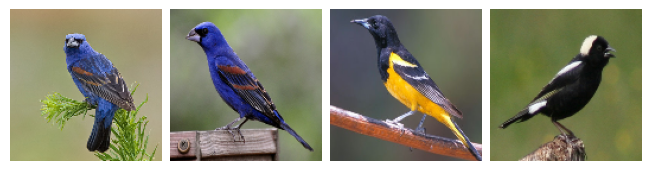

In [11]:
fig, axs = plt.subplots(1, 4, dpi=100, constrained_layout=True)

for img, ax in zip([img1, img2, img3, img4], axs):
    ax.imshow(depreprocess(img))
    ax.set_axis_off()

plt.show()


In [20]:
z1 = glow.inverse(tf.expand_dims(img1, 0))

z_shape = glow.inverse_event_shape(hps["OUTPUT_SHAPE"])

ztake = [
    round(bs[1] * 4 ** (i + math.log2(hps["IMAGE_SIZE"]) - hps["NUM_GLOW_BLOCKS"]))
    for i, bs in enumerate(glow.blockwise_splits)
]
total_z_taken = sum(ztake)
split_sizes = [z_shape.as_list()[0] - total_z_taken] + ztake
zsplits = tf.split(z1, num_or_size_splits=split_sizes, axis=-1)

print(f"[s.shape for s in zsplits]: {[s.shape for s in zsplits]}")


[s.shape for s in zsplits]: [TensorShape([1, 1536]), TensorShape([1, 0]), TensorShape([1, 1536]), TensorShape([1, 3072]), TensorShape([1, 6144]), TensorShape([1, 12288]), TensorShape([1, 24576])]


In [21]:
rebuild = tf.concat(zsplits, 1)

print(rebuild.shape)
print(tf.reduce_all(rebuild == z1))


(1, 49152)
tf.Tensor(True, shape=(), dtype=bool)


In [22]:
x1 = glow(rebuild)


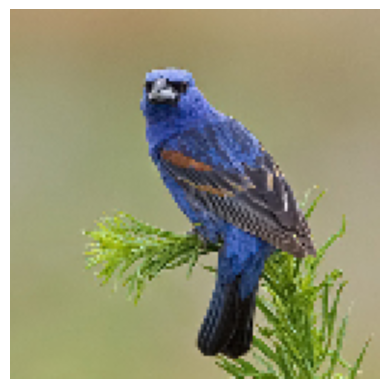

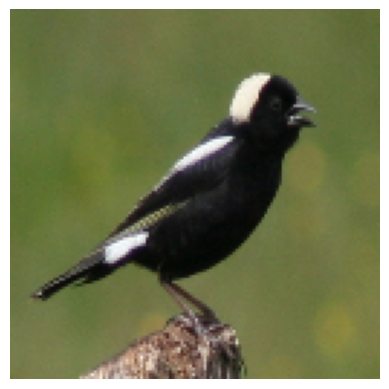

(128, 128, 3) (128, 128, 3)
tf.Tensor(0.163656, shape=(), dtype=float32)


In [23]:
plt.imshow(depreprocess(img1))
plt.gca().set_axis_off()

plt.figure()

plt.imshow(depreprocess(x1[0]))
plt.gca().set_axis_off()

plt.show()

print(img1.shape, x1[0].shape)
print(tf.reduce_mean(img1 - x1[0]))


In [11]:
blocks = hps["NUM_GLOW_BLOCKS"]

resamples_demo = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if blocks - i > j - 1:
            splits.append(1)
        else:
            splits.append(0)

    resamples_demo.append(splits)

print(resamples_demo)


[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0]]


In [25]:
blocks = hps["NUM_GLOW_BLOCKS"]

resamples = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if blocks - i > j - 1:
            splits.append(zsplits[j])
        else:
            splits.append(tf.zeros_like(zsplits[j]))

    resamples.append(tf.concat(splits, 1))


In [26]:
xis = []

for resample in tqdm(resamples):
    xis.append(glow(resample))


  0%|          | 0/6 [00:00<?, ?it/s]

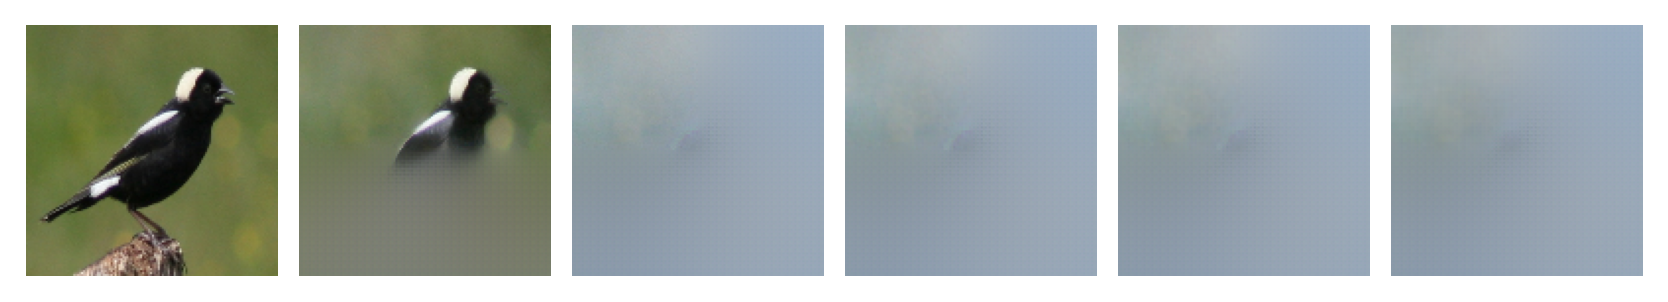

In [27]:
fig, axs = plt.subplots(1, len(xis), dpi=200, constrained_layout=True)

for img, ax in zip(xis, axs):
    ax.imshow(depreprocess(img[0]))
    ax.set_axis_off()

plt.show()


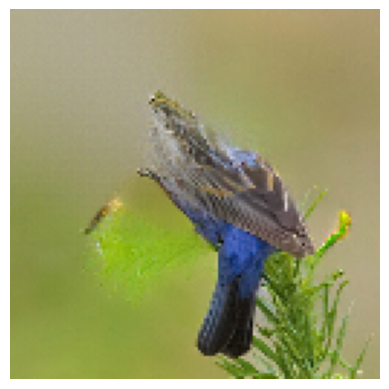

In [79]:
# Only set the most important partition to 0
resampled = tf.concat(
    [
        tf.zeros_like(zsplits[0]),
        zsplits[1],
        zsplits[2],
        zsplits[3],
        zsplits[4],
        zsplits[5],
        zsplits[6],
    ],
    1,
)
xi = glow(resampled)

plt.imshow(depreprocess(xi[0]))
plt.gca().set_axis_off()

plt.show()
